In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

In [2]:
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting.metrics import MAE, RMSE

In [3]:
import pandas as pd
import numpy as np

In [4]:
from pytorch_forecasting.data import examples
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting.data import NaNLabelEncoder

In [5]:
import torch

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## Electricity

In [7]:
electricity = pd.read_table('../data/LD2011_2014.txt', sep=';', decimal=',')

In [8]:
dates = electricity[electricity.reset_index().index % 4 == 3]["Unnamed: 0"].reset_index().drop(columns=["index"]).to_numpy()

In [9]:
electricity = electricity.groupby(electricity.index // 4).sum()

In [10]:
electricity["time_idx"] = [x for x in range(electricity.shape[0])]
electricity["group"] = 0
electricity["date"] = dates

In [11]:
electricity

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,time_idx,group,date
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2011-01-01 01:00:00
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,2011-01-01 02:00:00
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0,2011-01-01 03:00:00
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,2011-01-01 04:00:00
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,2011-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,7.614213,110.241821,6.950478,821.138211,385.365854,1532.738095,47.484454,1380.471380,412.587413,343.010753,...,9568.181818,284.224250,19.894675,1840.210711,160.267112,2764.662757,34918.918919,35059,0,2014-12-31 20:00:00
35060,8.883249,97.439545,6.950478,713.414634,359.756098,1324.404762,45.223290,1188.552189,351.398601,313.978495,...,8340.909091,298.565841,16.383850,1357.330992,525.876461,2722.873900,32864.864865,35060,0,2014-12-31 21:00:00
35061,10.152284,90.327169,6.950478,650.406504,351.219512,1267.857143,46.353872,1074.074074,293.706294,276.344086,...,5704.545455,294.654498,17.554125,2047.410009,661.101836,2647.360704,33189.189189,35061,0,2014-12-31 22:00:00
35062,8.883249,88.193457,6.950478,630.081301,339.024390,1247.023810,45.223290,1026.936027,283.216783,292.473118,...,5454.545455,220.338983,30.427150,2796.312555,784.641068,2709.677419,30108.108108,35062,0,2014-12-31 23:00:00


In [12]:
# Standardize
tmp_train = electricity[(electricity["time_idx"] >= 26303) & (electricity["time_idx"] < 32135)][electricity.columns[:-3]]
avg = tmp_train.mean()
sd = tmp_train.std()
tmp_train = (tmp_train-avg)/sd
tmp_test = electricity[electricity["time_idx"] >= 32135][electricity.columns[:-3]]
tmp_test = (tmp_test-avg)/sd

In [13]:
electricity.loc[26303:32135, electricity.columns[:-3]] = tmp_train
electricity.loc[32135:, electricity.columns[:-3]] = tmp_test

In [14]:
electricity[electricity["date"] == "2014-01-01 00:00:00"]

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,time_idx,group,date
26303,-0.325712,-0.325672,0.078889,0.700606,1.509027,1.576605,0.160981,0.087299,0.36643,0.989282,...,-1.113158,-1.290248,-0.187259,-2.115708,-1.13995,-0.685039,-2.867798,26303,0,2014-01-01 00:00:00


In [15]:
electricity[electricity["date"] == "2014-09-01 00:00:00"]

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,time_idx,group,date
32135,2.177065,1.067456,0.078889,0.139374,0.181667,-0.21036,-0.337187,-0.069101,-0.192547,-0.120699,...,-0.196131,0.197709,-0.204664,0.65294,-1.091678,-0.212042,0.836799,32135,0,2014-09-01 00:00:00


In [16]:
training = TimeSeriesDataSet(electricity[lambda x: (x.time_idx >= 26303) & (x.time_idx < 32135)], time_idx="time_idx",
                             target="MT_001", group_ids=["group"],
                             time_varying_known_reals=[],
                             time_varying_unknown_reals=["MT_001"],
                             max_encoder_length=168, max_prediction_length=24)
testing = TimeSeriesDataSet.from_dataset(training, electricity[lambda x: x.time_idx >= 32135],
                                         stop_randomization=True)

In [17]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=64, num_workers=0)

In [18]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

In [19]:
trainer = pl.Trainer(
    max_epochs=200,
    gpus=-1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=15,
    limit_val_batches=3,
    callbacks=[lr_logger, early_stop_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [20]:
deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=40,
    rnn_layers=3,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")

Number of parameters in network: 33.2k


In [21]:
trainer.fit(deepar, train_dataloader=train_dataloader, val_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 33.1 K
4 | distribution_projector | Linear                 | 82    
------------------------------------------------------------------
33.2 K    Trainable params
0         Non-trainable params
33.2 K    Total params
0.133     Total estimated model params size (MB)


Validation sanity check:   0%|                           | 0/2 [00:00<?, ?it/s]

C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_forecasting\data\timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  83%|▊| 15/18 [00:01<00:00,  7.77it/s, loss=4.16, v_num=12, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 0:  94%|▉| 17/18 [00:02<00:00,  8.14it/s, loss=4.16, v_num=12, sanity_che
Epoch 0: 100%|█| 18/18 [00:02<00:00,  7.96it/s, loss=4.16, v_num=12, sanity_che
Epoch 1:   0%| | 0/18 [00:00<?, ?it/s, loss=4.16, v_num=12, sanity_check_loss=1

C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Epoch 1:  89%|▉| 16/18 [00:01<00:00, 10.97it/s, loss=3.54, v_num=12, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 1: 100%|█| 18/18 [00:01<00:00, 10.92it/s, loss=3.54, v_num=12, sanity_che
Epoch 1: 100%|█| 18/18 [00:01<00:00, 10.04it/s, loss=3.54, v_num=12, sanity_che
Epoch 2:  89%|▉| 16/18 [00:01<00:00, 10.52it/s, loss=2.83, v_num=12, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 2: 100%|█| 18/18 [00:01<00:00, 10.45it/s, loss=2.83, v_num=12, sanity_che
Epoch 2: 100%|█| 18/18 [00:01<00:00,  9.75it/s, loss=2.83, v_num=12, sanity_che
Epoch 3:  89%|▉| 16/18 [00:01<00:00, 10.99it/s, loss=2.99, v_num=12, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 3: 100%|█| 18/18 [00:01<00:00, 10.73it/s, loss=2.99, v_num=12, sanity_che
Epoch 3: 100%|█| 18/18 [00:

Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 23: 100%|█| 18/18 [00:01<00:00, 10.09it/s, loss=0.765, v_num=12, sanity_c
Epoch 23: 100%|█| 18/18 [00:01<00:00,  9.48it/s, loss=0.765, v_num=12, sanity_c
Epoch 24:  83%|▊| 15/18 [00:01<00:00,  9.92it/s, loss=0.715, v_num=12, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 24: 100%|█| 18/18 [00:01<00:00, 10.21it/s, loss=0.715, v_num=12, sanity_c
Epoch 24: 100%|█| 18/18 [00:01<00:00,  9.57it/s, loss=0.715, v_num=12, sanity_c
Epoch 25:  83%|▊| 15/18 [00:01<00:00,  9.52it/s, loss=0.679, v_num=12, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 25: 100%|█| 18/18 [00:01<00:00,  9.83it/s, loss=0.679, v_num=12, sanity_c
Epoch 25: 100%|█| 18/18 [00:01<00:00,  9.27it/s, loss=0.679, v_num=12, sanity_c
Epoch 26:  83%|▊| 15/18 [00:01<00:00,  9.65it/s, loss=0.65

In [137]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = deepar.predict(test_dataloader)

In [138]:
print(((actuals-predictions)**2).mean()) #MSE
print((actuals-predictions).abs().mean()) #MAE

tensor(0.1976)
tensor(0.2076)


In [200]:
def ND(prediction, Y):
    return abs((prediction - Y)).sum() / abs(Y).sum()

def RMSE(prediction, Y):
    return np.sqrt(((actuals-predictions)**2).mean())

In [140]:
ND(predictions, actuals)

tensor(0.3690)

In [203]:
RMSE(predictions, actuals)

tensor(0.9875)

In [22]:
raw_predictions, x = deepar.predict(test_dataloader, mode="raw", return_x=True)

In [23]:
x["encoder_target"][0]

tensor([ 2.1771,  2.1202,  2.1771,  2.1202,  2.1771,  2.1202,  2.1771,  3.0303,
         2.3477,  1.8927,  3.1440,  1.8358,  1.8358,  1.8358,  1.8927,  1.8927,
         1.8358,  1.7789,  1.8927,  2.6890, -0.0413, -0.2688,  0.6982,  2.1771,
         0.1862, -0.1551, -0.1551, -0.1551, -0.0413, -0.1551, -0.1551, -0.0982,
        -0.3257, -0.3257,  1.4376,  1.8927,  1.8927,  1.8927,  1.8927,  2.1771,
         2.4046,  1.9495,  1.9495,  1.9495,  3.2009,  2.0633,  2.1202,  2.1771,
         2.1771,  2.1202,  2.2339,  2.1202,  2.1202,  2.1771,  2.1202,  3.4285,
         2.1771,  3.0303,  2.0633,  1.9495,  1.8927,  1.8927,  1.8927,  1.8927,
         1.8927,  1.8927,  2.7459,  2.5752,  2.0633,  2.1771,  2.2908,  1.4945,
         0.0156,  2.1202,  2.2908,  2.1771,  2.2339,  2.2908,  2.2339,  3.2009,
         2.0633,  2.8596,  2.0633,  1.8927,  1.8927,  1.8927,  1.8358,  1.3807,
         1.3238,  1.8927,  2.5184,  2.8028,  2.0064,  2.1202,  2.2339,  2.2908,
         1.6651,  0.0156,  2.2908,  2.17

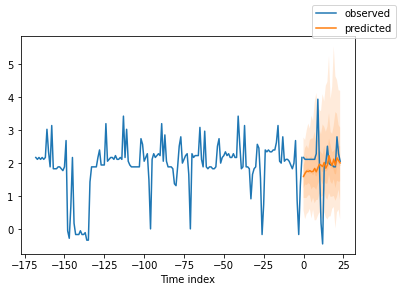

In [25]:
deepar.plot_prediction(x, raw_predictions, idx=0, quantiles_kwargs={'use_metric': False}, prediction_kwargs={'use_metric': False})
#plt.savefig("../report/images/deepar_electricity.png", facecolor="white", bbox_inches="tight")

## Traffic

In [26]:
traffic = pd.read_csv("../data/traffic.txt", header=None)
traffic.rename(lambda x: "r_"+str(x), inplace=True, axis=1)
traffic

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,r_852,r_853,r_854,r_855,r_856,r_857,r_858,r_859,r_860,r_861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,0.0409,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,0.0386,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,0.0360,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [27]:
traffic["time_idx"] = [x for x in range(traffic.shape[0])]
traffic["group"] = 0

In [28]:
# Standardize
tmp_train = traffic[traffic["time_idx"] < 14034][traffic.columns[:-2]]
avg = tmp_train.mean()
sd = tmp_train.std()
tmp_train = (tmp_train-avg)/sd
tmp_test = traffic[traffic["time_idx"] >= 14034][traffic.columns[:-2]]
tmp_test = (tmp_test-avg)/sd

In [29]:
traffic.loc[:14034, traffic.columns[:-2]] = tmp_train
traffic.loc[14034:, traffic.columns[:-2]] = tmp_test

In [30]:
training = TimeSeriesDataSet(traffic[lambda x: x.time_idx < 14034], time_idx="time_idx",
                             target="r_0", group_ids=["group"],
                             time_varying_known_reals=[],
                             time_varying_unknown_reals=["r_0"],
                             max_encoder_length=168, max_prediction_length=24)
testing = TimeSeriesDataSet.from_dataset(training, traffic[lambda x: x.time_idx >= 14034],
                                         stop_randomization=True)

In [31]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=1)
test_dataloader = testing.to_dataloader(train=False, batch_size=64, num_workers=1)

In [32]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=200,
    gpus=-1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=15,
    limit_val_batches=3,
    callbacks=[lr_logger, early_stop_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [33]:
deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=40,
    rnn_layers=3,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")

Number of parameters in network: 33.2k


In [34]:
trainer.fit(deepar, train_dataloader=train_dataloader, val_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 33.1 K
4 | distribution_projector | Linear                 | 82    
------------------------------------------------------------------
33.2 K    Trainable params
0         Non-trainable params
33.2 K    Total params
0.133     Total estimated model params size (MB)


Validation sanity check:   0%|                           | 0/2 [00:00<?, ?it/s]

C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  83%|▊| 15/18 [00:04<00:00,  3.34it/s, loss=1.52, v_num=13, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 0: 100%|█| 18/18 [00:08<00:00,  2.06it/s, loss=1.52, v_num=13, sanity_che
Epoch 1:  89%|▉| 16/18 [00:04<00:00,  3.59it/s, loss=1.53, v_num=13, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 1: 100%|█| 18/18 [00:08<00:00,  2.05it/s, loss=1.53, v_num=13, sanity_che
Epoch 2:  89%|▉| 16/18 [00:04<00:00,  3.50it/s, loss=1.52, v_num=13, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 2: 100%|█| 18/18 [00:09<00:00,  1.90it/s, loss=1.52, v_num=13, sanity_che
Epoch 3:  89%|▉| 16/18 [00:05<00:00,  3.18it/s, loss=1.53, v_num=13, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it

Epoch 28: 100%|█| 18/18 [00:09<00:00,  1.97it/s, loss=0.542, v_num=13, sanity_c
Epoch 29:  89%|▉| 16/18 [00:04<00:00,  3.48it/s, loss=0.545, v_num=13, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 29: 100%|█| 18/18 [00:08<00:00,  2.03it/s, loss=0.545, v_num=13, sanity_c
Epoch 30:  89%|▉| 16/18 [00:05<00:00,  3.17it/s, loss=0.514, v_num=13, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 30: 100%|█| 18/18 [00:09<00:00,  1.94it/s, loss=0.514, v_num=13, sanity_c
Epoch 31:  89%|▉| 16/18 [00:04<00:00,  3.50it/s, loss=0.505, v_num=13, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 31: 100%|█| 18/18 [00:08<00:00,  2.01it/s, loss=0.505, v_num=13, sanity_c
Epoch 32:  89%|▉| 16/18 [00:04<00:00,  3.37it/s, loss=0.44, v_num=13, sanity_ch
Validating: 0it [00:00, ?it

Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 57: 100%|█| 18/18 [00:08<00:00,  2.01it/s, loss=0.0703, v_num=13, sanity_
Epoch 58:  89%|▉| 16/18 [00:04<00:00,  3.32it/s, loss=0.0517, v_num=13, sanity_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 58: 100%|█| 18/18 [00:09<00:00,  1.97it/s, loss=0.0517, v_num=13, sanity_
Epoch 59:  89%|▉| 16/18 [00:04<00:00,  3.49it/s, loss=-0.0737, v_num=13, sanity
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 59: 100%|█| 18/18 [00:09<00:00,  1.93it/s, loss=-0.0737, v_num=13, sanity
Epoch 60:  89%|▉| 16/18 [00:05<00:00,  3.17it/s, loss=-0.0194, v_num=13, sanity
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 60: 100%|█| 18/18 [00:09<00:00,  1.92it/s, loss=-0.0194, v_num=13, sanity
Epoch 61:  89%|▉| 16/18 [00

In [194]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = deepar.predict(test_dataloader)

In [195]:
print(((actuals-predictions)**2).mean()) #MSE
print((actuals-predictions).abs().mean()) #MAE

tensor(0.9751)
tensor(0.4430)


In [196]:
ND(predictions, actuals)

tensor(0.6685)

In [204]:
RMSE(predictions, actuals)

tensor(0.9875)

In [35]:
raw_predictions, x = deepar.predict(test_dataloader, mode="raw", return_x=True)

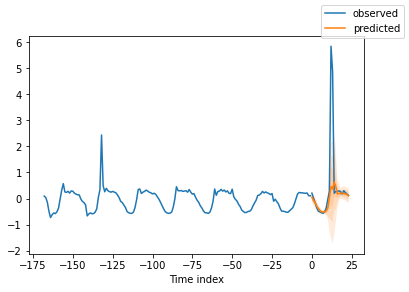

In [36]:
deepar.plot_prediction(x, raw_predictions, idx=0, quantiles_kwargs={'use_metric': False}, prediction_kwargs={'use_metric': False})
plt.savefig("../report/images/deepar_traffic.png", facecolor="white", bbox_inches="tight")

# ETT data

In [7]:
data = pd.read_csv("../data/ETTh1.csv", sep=",")
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [8]:
data["time_idx"] = [x for x in range(data.shape[0])]
data["group"] = 0
data["date"] = data["date"].apply(lambda x: pd.to_datetime(x))
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,time_idx,group
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,0,0
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1,0
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2,0
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,3,0
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,4,0
...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,17415,0
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,17416,0
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,17417,0
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,17418,0


In [9]:
# Standardize
numerical = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
column_std = dict()
for num in numerical:
    x = data.loc[:8760, num]
    avg = x.mean()
    std = x.std()
    column_std[num] = {"mean": avg, "std": std}
    data.loc[:8760, num] = (x-avg)/std # train
    data.loc[8760:, num] = (data.loc[8760:, num]-avg)/std # validation and test

In [10]:
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,time_idx,group
0,2016-07-01 00:00:00,-0.357881,-0.005243,-0.622758,-0.157085,1.387245,0.884899,1.464723,0,0
1,2016-07-01 01:00:00,-0.380904,0.026966,-0.642091,-0.175807,1.327451,0.933161,1.163926,1,0
2,2016-07-01 02:00:00,-0.472998,-0.134078,-0.680575,-0.212733,0.969664,0.694964,1.163926,2,0
3,2016-07-01 03:00:00,-0.484509,-0.037452,-0.680575,-0.194010,0.999071,0.789931,0.863238,3,0
4,2016-07-01 04:00:00,-0.438463,-0.037452,-0.642091,-0.157085,1.058865,0.789931,0.523854,4,0
...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.646673,0.735558,-1.926175,0.711442,0.670691,1.169801,-0.686791,17415,0
17416,2018-06-26 16:00:00,-2.302667,1.089854,-2.561623,0.785293,0.730485,1.406441,-0.671445,17416,0
17417,2018-06-26 17:00:00,-0.875735,0.864393,-1.059278,0.693239,0.909869,1.169801,-0.756181,17417,0
17418,2018-06-26 18:00:00,0.229043,0.864393,0.077011,0.693239,0.850075,1.028128,-0.810224,17418,0


In [11]:
# change max_prediction_length for forecasting window
training = TimeSeriesDataSet(data[lambda x: x.time_idx < 8760], time_idx="time_idx", target="OT", group_ids=["group"],
                             time_varying_known_reals=[], # "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"
                             time_varying_unknown_reals=["OT"],
                             max_encoder_length=720, max_prediction_length=720)
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: (x.time_idx >= 8760) & (x.time_idx < 11680)],
                                            stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, data[lambda x: (x.time_idx >= 11680) & (x.time_idx < 14600)],
                                            stop_randomization=True)

In [12]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=1)
test_dataloader = testing.to_dataloader(train=False, batch_size=64, num_workers=1)

In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

In [14]:
trainer = pl.Trainer(
    max_epochs=200,
    gpus=-1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=15,
    limit_val_batches=3,
    callbacks=[lr_logger, early_stop_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [15]:
deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=40,
    rnn_layers=3,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")

Number of parameters in network: 33.2k


In [16]:
trainer.fit(deepar, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 33.1 K
4 | distribution_projector | Linear                 | 82    
------------------------------------------------------------------
33.2 K    Trainable params
0         Non-trainable params
33.2 K    Total params
0.133     Total estimated model params size (MB)


Validation sanity check:   0%|                           | 0/2 [00:00<?, ?it/s]

C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  83%|▊| 15/18 [00:05<00:01,  2.61it/s, loss=2.46, v_num=11, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 0:  94%|▉| 17/18 [00:09<00:00,  1.79it/s, loss=2.46, v_num=11, sanity_che
Epoch 0: 100%|█| 18/18 [00:09<00:00,  1.81it/s, loss=2.46, v_num=11, sanity_che
                                                                               

C:\Users\dmoho\anaconda3\envs\suTSF\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Epoch 1:  89%|▉| 16/18 [00:05<00:00,  2.79it/s, loss=2.44, v_num=11, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 1: 100%|█| 18/18 [00:09<00:00,  1.87it/s, loss=2.44, v_num=11, sanity_che
Epoch 1: 100%|█| 18/18 [00:09<00:00,  1.80it/s, loss=2.44, v_num=11, sanity_che
Epoch 2:  89%|▉| 16/18 [00:05<00:00,  2.82it/s, loss=2.38, v_num=11, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 2: 100%|█| 18/18 [00:09<00:00,  1.88it/s, loss=2.38, v_num=11, sanity_che
Epoch 2: 100%|█| 18/18 [00:09<00:00,  1.80it/s, loss=2.38, v_num=11, sanity_che
Epoch 3:  89%|▉| 16/18 [00:05<00:00,  2.86it/s, loss=2.29, v_num=11, sanity_che
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 3: 100%|█| 18/18 [00:09<00:00,  1.91it/s, loss=2.29, v_num=11, sanity_che
Epoch 3: 100%|█| 18/18 [00:

Epoch 45: 100%|█| 18/18 [00:09<00:00,  1.83it/s, loss=-0.672, v_num=11, sanity_
Epoch 45: 100%|█| 18/18 [00:10<00:00,  1.77it/s, loss=-0.672, v_num=11, sanity_
Epoch 46:  89%|▉| 16/18 [00:05<00:00,  2.78it/s, loss=-0.68, v_num=11, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 46: 100%|█| 18/18 [00:09<00:00,  1.87it/s, loss=-0.68, v_num=11, sanity_c
Epoch 46: 100%|█| 18/18 [00:09<00:00,  1.81it/s, loss=-0.68, v_num=11, sanity_c
Epoch 47:  89%|▉| 16/18 [00:05<00:00,  2.73it/s, loss=-0.687, v_num=11, sanity_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 47: 100%|█| 18/18 [00:10<00:00,  1.80it/s, loss=-0.687, v_num=11, sanity_
Epoch 47: 100%|█| 18/18 [00:10<00:00,  1.74it/s, loss=-0.687, v_num=11, sanity_
Epoch 48:  89%|▉| 16/18 [00:05<00:00,  2.79it/s, loss=-0.691, v_num=11, sanity_
Validating: 0it [00:00, ?it/s]
Validating:   0%|          

Epoch 90:  89%|▉| 16/18 [00:05<00:00,  2.78it/s, loss=-0.773, v_num=11, sanity_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 90: 100%|█| 18/18 [00:09<00:00,  1.86it/s, loss=-0.773, v_num=11, sanity_
Epoch 90: 100%|█| 18/18 [00:10<00:00,  1.79it/s, loss=-0.773, v_num=11, sanity_
Epoch 91:  89%|▉| 16/18 [00:05<00:00,  2.73it/s, loss=-0.78, v_num=11, sanity_c
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 91: 100%|█| 18/18 [00:09<00:00,  1.84it/s, loss=-0.78, v_num=11, sanity_c
Epoch 91: 100%|█| 18/18 [00:10<00:00,  1.77it/s, loss=-0.78, v_num=11, sanity_c
Epoch 92:  89%|▉| 16/18 [00:05<00:00,  2.72it/s, loss=-0.782, v_num=11, sanity_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/3 [00:00<?, ?it/s]
Epoch 92: 100%|█| 18/18 [00:09<00:00,  1.83it/s, loss=-0.782, v_num=11, sanity_
Epoch 92: 100%|█| 18/18 [00

In [33]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = deepar.predict(test_dataloader)

In [34]:
print(((actuals-predictions)**2).mean()) #MSE
print((actuals-predictions).abs().mean()) #MAE

tensor(0.1677)
tensor(0.3426)


In [17]:
raw_predictions, x = deepar.predict(test_dataloader, mode="raw", return_x=True)

0


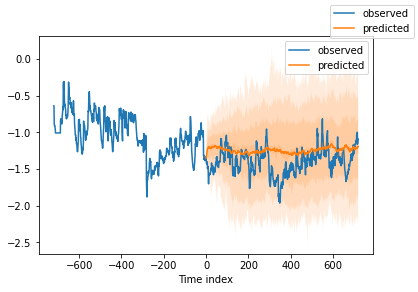

In [19]:
for idx in range(1):
    print(idx)
    deepar.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,
                           quantiles_kwargs={'use_metric': False}, prediction_kwargs={'use_metric': False})
    plt.legend()
    #plt.savefig("../images/deepar_eth.png", facecolor="white", bbox_inches="tight")